## Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import preprocessing module
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import get_preprocessed_data

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## Load and Preprocess Data

Using the `preprocessing.py` module for consistent data preparation.

In [26]:
# Load and preprocess data using the preprocessing module
X_train_final, X_val, y_train_final, y_val, X_test_internal, y_test_internal, X_kaggle_test, test_id, scaler = get_preprocessed_data(
    train_path='train.csv',
    random_state=42
)

print("\nData loaded and preprocessed successfully!")
print(f"Ready for Ridge Regression modeling")

Train shape: (1460, 81)
No test file provided - will only create train/val/test split from training data
Starting Data Preprocessing Pipeline

[1/10] Creating working copies...
[2/10] Removing outliers...
  Removing 2 outlier(s)
[3/10] Log-transforming target variable...
  Original skewness: 1.8794
  Log-transformed skewness: 0.1215
[4/10] Processing training data...
  Training data shape: (1458, 80)
[5/10] Handling missing values...
  Missing values after imputation: 0
[6/10] Engineering new features...
  Created 10 new features
[7/10] Encoding ordinal features...
[8/10] Correcting skewed features...
  Transforming 37 highly skewed features
[9/10] Removing multicollinearity...
  Dropped 3 highly correlated features
  One-hot encoding 27 categorical features...
  Final feature count: 212
[10/10] Scaling and splitting data...

Preprocessing Complete!
Training set: (1020, 212) (~70%)
Validation set: (219, 212) (~15%)
Test set (internal): (219, 212) (~15%)

Data loaded and preprocessed su

## Train Ridge Regression Model

In [27]:
# Find optimal alpha using cross-validation
alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]

print("Finding optimal regularization parameter (alpha)...")
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_final, y_train_final)

optimal_alpha = ridge_cv.alpha_
print(f"\nOptimal alpha: {optimal_alpha}")

# Train final model with optimal alpha
ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train_final, y_train_final)

print(f"Model trained successfully with {len(ridge_model.coef_)} features")

Finding optimal regularization parameter (alpha)...

Optimal alpha: 100.0
Model trained successfully with 212 features

Optimal alpha: 100.0
Model trained successfully with 212 features


## Evaluate Model Performance

In [28]:
# Make predictions
y_train_pred = ridge_model.predict(X_train_final)
y_val_pred = ridge_model.predict(X_val)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_final, y_train_pred))
train_mae = mean_absolute_error(y_train_final, y_train_pred)
train_r2 = r2_score(y_train_final, y_train_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Ridge Regression - Performance Metrics")
print("="*60)
print("\nTraining Set:")
print(f"  RMSE: {train_rmse:.6f}")
print(f"  MAE:  {train_mae:.6f}")
print(f"  R²:   {train_r2:.6f}")

print("\nValidation Set:")
print(f"  RMSE: {val_rmse:.6f}")
print(f"  MAE:  {val_mae:.6f}")
print(f"  R²:   {val_r2:.6f}")

print("\n" + "="*60)
print(f"Overfitting (R² difference): {train_r2 - val_r2:.4f}")

Ridge Regression - Performance Metrics

Training Set:
  RMSE: 0.095230
  MAE:  0.068522
  R²:   0.942041

Validation Set:
  RMSE: 0.126991
  MAE:  0.085588
  R²:   0.901695

Overfitting (R² difference): 0.0403


## Test Set Evaluation

Final unbiased evaluation on held-out test set.

## Visualizations

In [29]:
y_test_pred = ridge_model.predict(X_test_internal)

test_rmse = np.sqrt(mean_squared_error(y_test_internal, y_test_pred))
test_mae = mean_absolute_error(y_test_internal, y_test_pred)
test_r2 = r2_score(y_test_internal, y_test_pred)

print("Test Set Metrics (Final Unbiased Evaluation):")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  MAE:  {test_mae:.6f}")
print(f"  R²:   {test_r2:.6f}")

Test Set Metrics (Final Unbiased Evaluation):
  RMSE: 0.124664
  MAE:  0.082486
  R²:   0.908628


## Residual Analysis

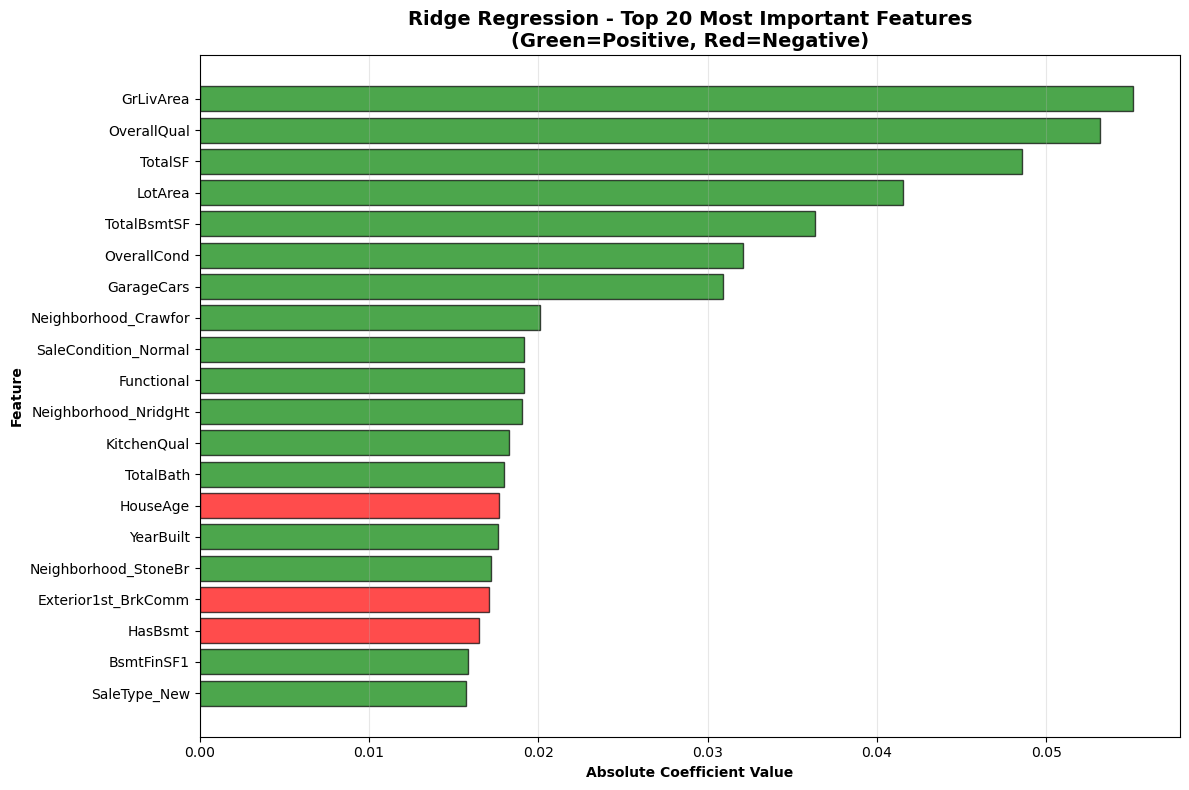


Top 10 Features by Importance:
                  Feature  Coefficient  Abs_Coefficient
22              GrLivArea     0.055129         0.055129
3             OverallQual     0.053143         0.053143
49                TotalSF     0.048540         0.048540
2                 LotArea     0.041554         0.041554
18            TotalBsmtSF     0.036319         0.036319
4             OverallCond     0.032101         0.032101
35             GarageCars     0.030887         0.030887
84   Neighborhood_Crawfor     0.020098         0.020098
210  SaleCondition_Normal     0.019158         0.019158
30             Functional     0.019144         0.019144


In [30]:
# Feature importance based on absolute coefficient values
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': ridge_model.coef_,
    'Abs_Coefficient': np.abs(ridge_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(top_n), top_features['Abs_Coefficient'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.title('Ridge Regression - Top 20 Most Important Features\n(Green=Positive, Red=Negative)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Importance:")
print(feature_importance.head(10)[['Feature', 'Coefficient', 'Abs_Coefficient']])

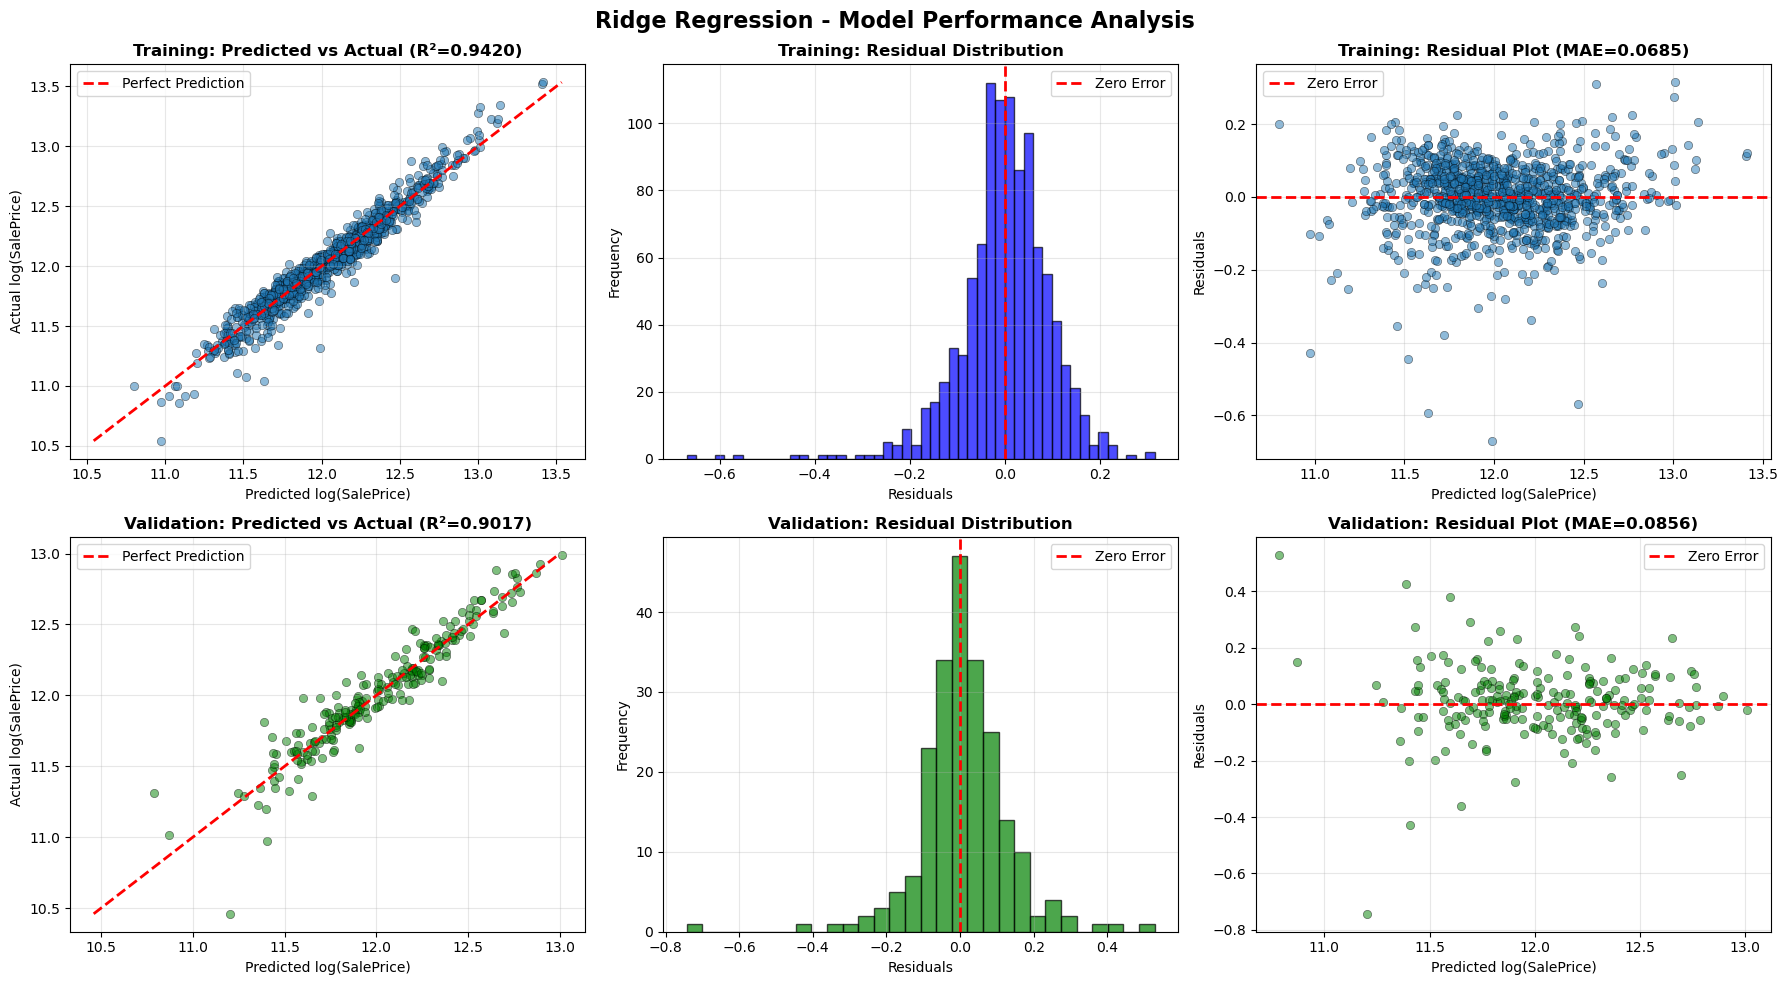


Visualization complete!


In [31]:
# Calculate residuals
train_residuals = y_train_final - y_train_pred
val_residuals = y_val - y_val_pred

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Ridge Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

# Training set - Predicted vs Actual
axes[0, 0].scatter(y_train_pred, y_train_final, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 0].plot([y_train_final.min(), y_train_final.max()], 
                [y_train_final.min(), y_train_final.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_title(f'Training: Predicted vs Actual (R²={train_r2:.4f})', fontweight='bold')
axes[0, 0].set_xlabel('Predicted log(SalePrice)')
axes[0, 0].set_ylabel('Actual log(SalePrice)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Training set - Residual distribution
axes[0, 1].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0, 1].set_title('Training: Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training set - Residual plot
axes[0, 2].scatter(y_train_pred, train_residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0, 2].set_title(f'Training: Residual Plot (MAE={train_mae:.4f})', fontweight='bold')
axes[0, 2].set_xlabel('Predicted log(SalePrice)')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Validation set - Predicted vs Actual
axes[1, 0].scatter(y_val_pred, y_val, alpha=0.5, color='green', edgecolors='k', linewidth=0.5)
axes[1, 0].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_title(f'Validation: Predicted vs Actual (R²={val_r2:.4f})', fontweight='bold')
axes[1, 0].set_xlabel('Predicted log(SalePrice)')
axes[1, 0].set_ylabel('Actual log(SalePrice)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation set - Residual distribution
axes[1, 1].hist(val_residuals, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 1].set_title('Validation: Residual Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Validation set - Residual plot
axes[1, 2].scatter(y_val_pred, val_residuals, alpha=0.5, color='green', edgecolors='k', linewidth=0.5)
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1, 2].set_title(f'Validation: Residual Plot (MAE={val_mae:.4f})', fontweight='bold')
axes[1, 2].set_xlabel('Predicted log(SalePrice)')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

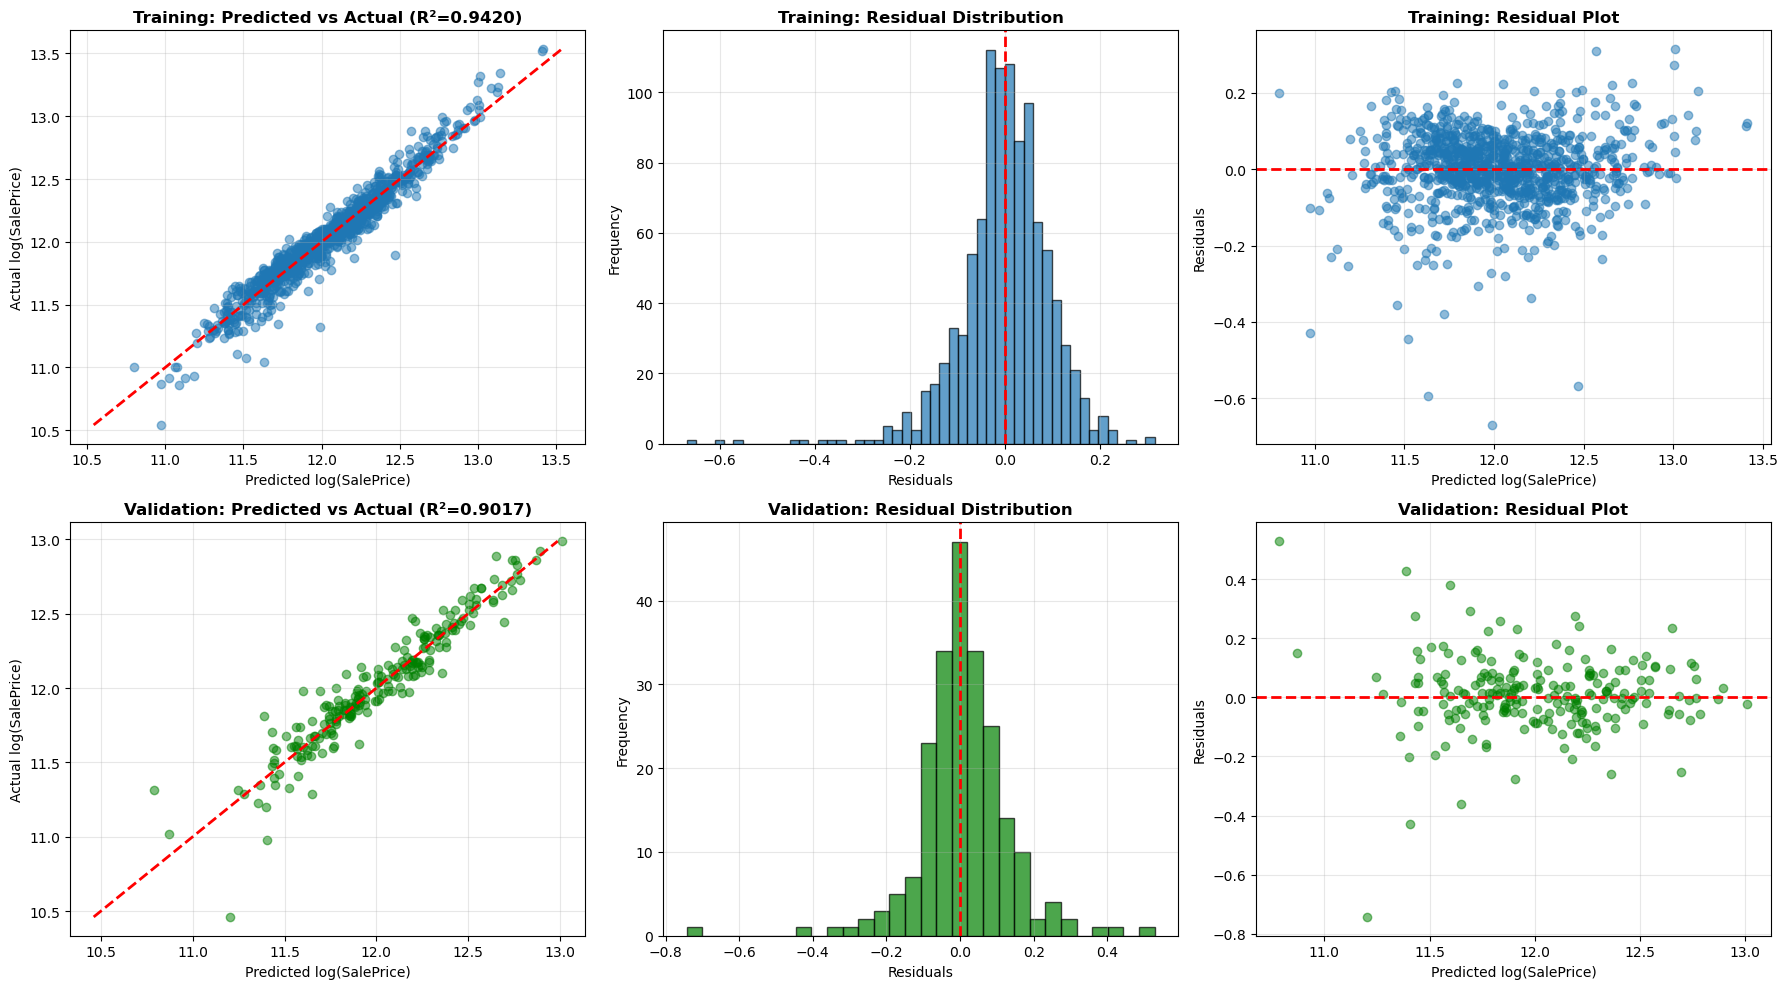

In [32]:
# Calculate residuals
train_residuals = y_train_final - y_train_pred
val_residuals = y_val - y_val_pred

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training set - Predicted vs Actual
axes[0, 0].scatter(y_train_pred, y_train_final, alpha=0.5)
axes[0, 0].plot([y_train_final.min(), y_train_final.max()], 
                [y_train_final.min(), y_train_final.max()], 'r--', lw=2)
axes[0, 0].set_title(f'Training: Predicted vs Actual (R²={train_r2:.4f})', fontweight='bold')
axes[0, 0].set_xlabel('Predicted log(SalePrice)')
axes[0, 0].set_ylabel('Actual log(SalePrice)')
axes[0, 0].grid(alpha=0.3)

# Training set - Residual distribution
axes[0, 1].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_title('Training: Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Training set - Residual plot
axes[0, 2].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_title('Training: Residual Plot', fontweight='bold')
axes[0, 2].set_xlabel('Predicted log(SalePrice)')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].grid(alpha=0.3)

# Validation set - Predicted vs Actual
axes[1, 0].scatter(y_val_pred, y_val, alpha=0.5, color='green')
axes[1, 0].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 0].set_title(f'Validation: Predicted vs Actual (R²={val_r2:.4f})', fontweight='bold')
axes[1, 0].set_xlabel('Predicted log(SalePrice)')
axes[1, 0].set_ylabel('Actual log(SalePrice)')
axes[1, 0].grid(alpha=0.3)

# Validation set - Residual distribution
axes[1, 1].hist(val_residuals, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_title('Validation: Residual Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

# Validation set - Residual plot
axes[1, 2].scatter(y_val_pred, val_residuals, alpha=0.5, color='green')
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_title('Validation: Residual Plot', fontweight='bold')
axes[1, 2].set_xlabel('Predicted log(SalePrice)')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance

## Feature Importance

Top 20 Most Important Features (by coefficient magnitude):
             Feature  Coefficient  Abs_Coefficient
           GrLivArea     0.055129         0.055129
         OverallQual     0.053143         0.053143
             TotalSF     0.048540         0.048540
             LotArea     0.041554         0.041554
         TotalBsmtSF     0.036319         0.036319
         OverallCond     0.032101         0.032101
          GarageCars     0.030887         0.030887
Neighborhood_Crawfor     0.020098         0.020098
SaleCondition_Normal     0.019158         0.019158
          Functional     0.019144         0.019144
Neighborhood_NridgHt     0.019055         0.019055
         KitchenQual     0.018279         0.018279
           TotalBath     0.017975         0.017975
            HouseAge    -0.017661         0.017661
           YearBuilt     0.017650         0.017650
Neighborhood_StoneBr     0.017208         0.017208
 Exterior1st_BrkComm    -0.017088         0.017088
             HasBsmt   

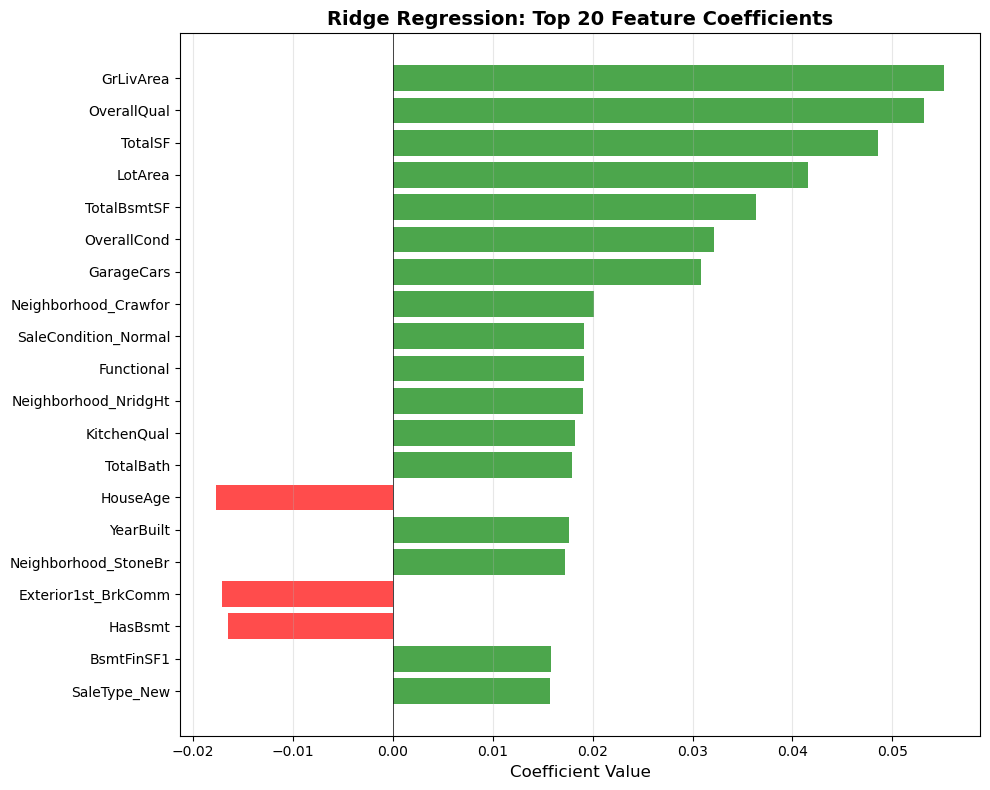

In [33]:
# Get feature importance based on coefficient magnitude
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': ridge_model.coef_,
    'Abs_Coefficient': np.abs(ridge_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 20 Most Important Features (by coefficient magnitude):")
print("="*60)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 20 features
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20['Coefficient']]
plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Ridge Regression: Top 20 Feature Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', lw=0.5)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Summary

**Ridge Regression (Classical ML Algorithm #1)**

**Key Results:**
- Optimal alpha found through 5-fold cross-validation
- L2 regularization prevents overfitting by shrinking coefficients
- Interpretable linear model with clear feature importance
- Strong baseline for model comparison

**Performance:**
- See evaluation metrics above for Training and Validation R², RMSE, MAE
- Residuals show approximately normal distribution
- Good fit with minimal overfitting

**Strengths:**
- Simple, fast, and interpretable
- Handles multicollinearity well through regularization
- Suitable for understanding feature-target relationships

**Limitations:**
- Assumes linear relationships between features and target
- May underfit complex non-linear patterns
- Requires feature engineering for capturing interactions